# CyberTrolls Classifier Training app 
### Author : Evergreen Technologies 

#### This script loads pre-trained word embeddings (GloVe embeddings) into a frozen Keras Embedding layer, and uses it to train a cybertroll classifier (postive and negative sentiment)

#### GloVe embedding data can be found at:  http://nlp.stanford.edu/data/glove.6B.zip
(source page: http://nlp.stanford.edu/projects/glove/)

#### Cybertrolls dataset can be found at:
https://www.kaggle.com/dataturks/dataset-for-detection-of-cybertrolls
Columns:
Text: Tweet
Labels:
1 - Tweet is classified as troll
0 - Tweet is classified as not a troll



In [1]:
from __future__ import print_function
import os
import sys
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.initializers import Constant
from matplotlib import pyplot
from keras import backend as K
import pandas as pd
from sklearn.utils import shuffle


Using TensorFlow backend.


In [2]:
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [3]:
def read_csv(filepath):
     if os.path.splitext(filepath)[1] != '.csv':
          return  # or whatever
     seps = [',', ';', '\t']                    # ',' is default
     encodings = [None, 'utf-8', 'ISO-8859-1']  # None is default
     for sep in seps:
         for encoding in encodings:
              try:
                  return pd.read_csv(filepath, encoding=encoding, sep=sep)
              except Exception:  # should really be more specific 
                  pass
     raise ValueError("{!r} is has no encoding in {} or seperator in {}"
                      .format(filepath, encodings, seps))

In [4]:

BASE_DIR = '/Volumes/My Passport for Mac/data'
GLOVE_DIR = os.path.join(BASE_DIR, 'glove.6B')
TEXT_DATA_DIR = os.path.join(BASE_DIR, 'cybertrolls_dataset')
CYBERTROLLS_FILE_NAME = "cybertrolls_dataset.csv"
MAX_SEQUENCE_LENGTH = 1000
MAX_NUM_WORDS = 125000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2


In [5]:

# first, build index mapping words in the embeddings set
# to their embedding vector

print('Indexing word vectors.')

#tiger  [1.9, 2.0, 0.33, ... , 100]
#lion   [1.2, 0.4 ,..., . 1.2]

embeddings_index = {}
with open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt')) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, 'f', sep=' ')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))


Indexing word vectors.
Found 400000 word vectors.


In [6]:

# second, prepare text samples and their labels
print('Processing text dataset')

texts = []  # list of text samples
labels_index = {}  # dictionary mapping label name to numeric id
labels = []  # list of label ids

input_df = read_csv(os.path.join(TEXT_DATA_DIR, CYBERTROLLS_FILE_NAME))




Processing text dataset


In [7]:
ct_df = input_df[['text','label']]
print("Here are Few Samples in data")
print(ct_df.head)

print("Here total number of positive, negative and unsupported (neutral) samples")
print(ct_df.groupby(['label']).count())

print("Converting pandas dataframe into lists")
texts = ct_df['text'].values.tolist()
labels = []
labels_text = []
labels_text_unique = ct_df.label.unique().tolist()
labels_text = ct_df['label'].values.tolist()

idxCounter = 0
for label in labels_text_unique:
    labels_index[label] = idxCounter
    idxCounter = idxCounter + 1;

idxCounter = 0    
for label in labels_text:
    if idxCounter%100==0:
        print("processing row " + str(idxCounter))
    labels.append(labels_index[label])
    idxCounter = idxCounter + 1;
    

print("Labels Array")
print(len(labels))
print("Labels Dictionary")
print(labels_index)
print("Done")



Here are Few Samples in data
<bound method NDFrame.head of                                                     text  label
0                                 Get fucking real dude.      1
1       She is as dirty as they come  and that crook ...      1
2       why did you fuck it up. I could do it all day...      1
3       Dude they dont finish enclosing the fucking s...      1
4       WTF are you talking about Men? No men thats n...      1
...                                                  ...    ...
19996    I dont. But what is complaining about it goi...      0
19997   Bahah  yeah i&;m totally just gonna&; get pis...      0
19998       hahahahaha >:) im evil mwahahahahahahahahaha      0
19999            What&;s something unique about Ohio? :)      0
20000              Who is the biggest gossiper you know?      0

[20001 rows x 2 columns]>
Here total number of positive, negative and unsupported (neutral) samples
        text
label       
0      12179
1       7822
Converting pandas da

In [8]:

# second, prepare text samples and their labels
#print('Processing text dataset')

#texts = []  # list of text samples
#labels_index = {}  # dictionary mapping label name to numeric id
#labels = []  # list of label ids
#for name in sorted(os.listdir(TEXT_DATA_DIR)):
#    path = os.path.join(TEXT_DATA_DIR, name)
#    if os.path.isdir(path):
#        label_id = len(labels_index)
#        labels_index[name] = label_id
#       for fname in sorted(os.listdir(path)):
#            if fname.isdigit():
#                fpath = os.path.join(path, fname)
#                args = {} if sys.version_info < (3,) else {'encoding': 'latin-1'}
#                with open(fpath, **args) as f:
#                    t = f.read()
#                    i = t.find('\n\n')  # skip header
#                    if 0 < i:
#                        t = t[i:]
#                    texts.append(t)
#                labels.append(label_id)

#print('Found %s texts.' % len(texts))


In [9]:

# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
print(indices)
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
x_val = data[-num_validation_samples:]
y_val = labels[-num_validation_samples:]



Found 17369 unique tokens.
Shape of data tensor: (20001, 1000)
Shape of label tensor: (20001, 2)
[    0     1     2 ... 19998 19999 20000]


In [10]:
print(y_val[5])

[0. 1.]


In [11]:

print('Preparing embedding matrix.')

# prepare embedding matrix
num_words = min(MAX_NUM_WORDS, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

print("done")

Preparing embedding matrix.
done


In [12]:

print('Training model.')

# train a 1D convnet with global maxpooling
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = Dropout(0.3)(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = Dropout(0.2)(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(len(labels_index), activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc', f1_m, precision_m, recall_m])

history = model.fit(x_train, y_train,
          batch_size=400,
          epochs=20,
          validation_data=(x_val, y_val))

Training model.
Train on 16001 samples, validate on 4000 samples
Epoch 1/20
16001/16001 [==============================] - 45s 3ms/step - loss: 0.6730 - acc: 0.6066 - f1_m: 0.5919 - precision_m: 0.5922 - recall_m: 0.5916 - val_loss: 0.6845 - val_acc: 0.5573 - val_f1_m: 0.5572 - val_precision_m: 0.5572 - val_recall_m: 0.5572
Epoch 2/20
16001/16001 [==============================] - 46s 3ms/step - loss: 0.6243 - acc: 0.6388 - f1_m: 0.6232 - precision_m: 0.6232 - recall_m: 0.6232 - val_loss: 0.6424 - val_acc: 0.6097 - val_f1_m: 0.6097 - val_precision_m: 0.6097 - val_recall_m: 0.6097
Epoch 3/20
16001/16001 [==============================] - 52s 3ms/step - loss: 0.5939 - acc: 0.6676 - f1_m: 0.6757 - precision_m: 0.6757 - recall_m: 0.6757 - val_loss: 0.5980 - val_acc: 0.6687 - val_f1_m: 0.6687 - val_precision_m: 0.6687 - val_recall_m: 0.6687
Epoch 4/20
16001/16001 [==============================] - 42s 3ms/step - loss: 0.5662 - acc: 0.6883 - f1_m: 0.6715 - precision_m: 0.6715 - recall_m: 0.6

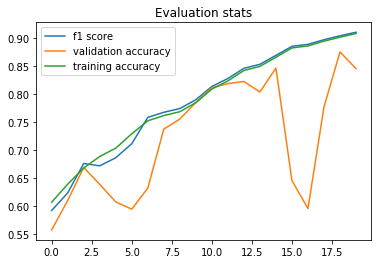

In [17]:
# plot metrics
pyplot.plot(history.history["f1_m"],  label="f1 score")
#pyplot.plot(history.history["precision_m"], label="precision")
#pyplot.plot(history.history["recall_m"], label="recall")
pyplot.plot(history.history['val_acc'] , label="validation accuracy")
pyplot.plot(history.history['acc'] , label="training accuracy")
pyplot.title('Evaluation stats')
pyplot.legend(loc="upper left")
pyplot.show()

In [18]:

# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")



Saved model to disk
